## pix2pix(U-Net + GAN) experiments

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tnrange, tqdm_notebook

### Model definitions

In [2]:
from keras import objectives
from keras import backend as K
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.layers import Input
from keras.layers.merge import concatenate
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D, Conv2DTranspose, Cropping2D
from keras.layers.core import Activation, Dropout

Using TensorFlow backend.


In [3]:
# U-Net Generator
def g_unet(nf, model_name, in_ch=1, out_ch=1, batch_size=1, alpha=0.2):
    ''' параметры:
    input shape = (100, 100, in_ch)
    output = (100, 250, out_ch)
    nf - число фильтров на входном слое
    alpha - параметр LeakyReLU
    '''
    i = Input(shape=(100, 100, in_ch))
    # (100, 100, in_ch)
    
    conv1 = Conv2D(nf, (6, 6), padding='same', strides=(5, 5))(i)
    conv1 = BatchNormalization(axis=3)(conv1)
    x = LeakyReLU(alpha)(conv1)
    # (20, 20, nf)
    
    conv2 = Conv2D(nf*5, (6, 6), padding='same', strides=(5, 5))(x)
    conv2 = BatchNormalization(axis=3)(conv2)
    x = LeakyReLU(alpha)(conv2)
    # (4, 4, nf*5)
    
    conv3 = Conv2D(nf*10, (3, 3), padding='same', strides=(2, 2))(x)
    conv3 = BatchNormalization(axis=3)(conv3)
    x = LeakyReLU(alpha)(conv3)
    # (2, 2, nf*10)

    conv4 = Conv2D(nf*10, (2, 2), padding='valid', strides=(1, 1))(x)
    conv4 = BatchNormalization(axis=3)(conv4)
    x = LeakyReLU(alpha)(conv4)
    # (1, 1, nf*10)

    dconv1 = Conv2DTranspose(nf*10, (2, 2), strides=(1, 1))(x)
    dconv1 = BatchNormalization(axis=3)(dconv1)
    dconv1 = Dropout(0.5)(dconv1)
    x = concatenate([dconv1, conv3], axis=3)
    x = LeakyReLU(alpha)(x)
    # (2, 2, nf*(10 + 10))

    dconv2 = Conv2DTranspose(nf*5, (2, 2), strides=(2, 2))(x)
    dconv2 = BatchNormalization(axis=3)(dconv2)
    x = concatenate([dconv2, conv2], axis=3)
    x = LeakyReLU(alpha)(x)
    # (4, 4, nf*(5 + 5))

    dconv3 = Conv2DTranspose(nf, (2, 2), strides=(5, 5))(x)
    dconv3 = BatchNormalization(axis=3)(dconv3)
    x = concatenate([dconv3, conv1], axis=3)
    x = LeakyReLU(alpha)(x)
    # (20, 20, nf*(1 + 1))

    dconv4 = Conv2DTranspose(out_ch, (2, 2), strides=(13, 5))(x)
    # (260, 100, out_ch)
    
    dconv4 = Cropping2D((5, 0))(dconv4)
    # (250, 100, out_ch)

    out = Activation('tanh')(dconv4)
    unet = Model(i, out, name=model_name)
    
    return unet

In [4]:
# Discriminator
def discriminator(nf, a_ch=1, b_ch=1, c_ch=1, opt=Adam(lr=2e-4, beta_1=0.5), alpha=0.2, model_name='d'):
    ''' параметры:
    a_ch - число каналов первого изображения
    b_ch - число каналов второго
    c_ch - третьего
    nf - число фильтров на входном слое
    alpha - параметр LeakyReLU
    '''
    i1 = Input(shape=(100, 100, a_ch + b_ch))
    # (100, 100, a_ch + b_ch) - side1 + side2
    
    i2 = Input(shape=(500, 100, c_ch))
    # (500, 100, c_ch) - panorama
    
    conv0 = Conv2D(c_ch, (6,2), padding='same', strides=(5,1))(i2)
    # (100, 100, c_ch)
    
    i = concatenate([i1, conv0], axis=3)
    # (100, 100, a_ch + b_ch + c_ch)
    
    conv1 = Conv2D(nf, (6, 6), padding='same', strides=(5,5))(i)
    x = LeakyReLU(alpha)(conv1)
    # (20, 20, nf)
    
    conv2 = Conv2D(nf*5, (6, 6), padding='same', strides=(5,5))(x)
    x = LeakyReLU(alpha)(conv2)
    # (4, 4, nf*5)
    
    conv3 = Conv2D(1, (3, 3), padding='same', strides=(2,2))(x)
    out = Activation('sigmoid')(conv3)
    # (2, 2, 1)
    
    d = Model([i1, i2], out, name=model_name)
    
    def d_loss(y_true, y_pred):
        L = objectives.binary_crossentropy(K.batch_flatten(y_true), K.batch_flatten(y_pred))
        return L
    
    d.compile(optimizer=opt, loss=d_loss)
    return d

In [5]:
def full_generator(nf, in_ch=1, out_ch=1, batch_size=1, alpha=0.2, model_name='f_gen'):
    a1 = Input(shape=(100, 100, in_ch))
    a2 = Input(shape=(100, 100, in_ch))
    gen1 = g_unet(nf, 'unet1', in_ch, out_ch, batch_size, alpha)
    out1 = gen1(a1)
    gen2 = g_unet(nf, 'unet2', in_ch, out_ch, batch_size, alpha)
    out2 = gen2(a2)
    out = concatenate([out1, out2], axis=1)
    f_gen = Model([a1, a2], out, name=model_name)
    return f_gen

In [6]:
def pix2pix(atob, d, a_ch=1, b_ch=1, alpha=100, opt=Adam(lr=2e-4, beta_1=0.5), model_name='pix2pix'):
    '''
    atob - full generator
    d - discriminator
    '''
    a1 = Input(shape=(100, 100, a_ch))
    a2 = Input(shape=(100, 100, a_ch))
    b = Input(shape=(500, 100, b_ch))
    
    # генерируем картинку на основе a1 и a2 с помощью объединенного генератора:
    bp = atob([a1, a2])
    
    # дискриминатор получает на вход пару изображений
    d_in = [concatenate([a1, a2], axis=3), bp]
    pix2pix = Model([a1, a2, b], d(d_in), name=model_name)
    
    def p2p_loss(y_true, y_pred):
        y_true_flat = K.batch_flatten(y_true)
        y_pred_flat = K.batch_flatten(y_pred)
        
        # adversarial loss
        L_adv = objectives.binary_crossentropy(y_true_flat, y_pred_flat)
        
        # atob loss
        b_flat = K.batch_flatten(b)
        bp_flat = K.batch_flatten(bp)
        L_atob = K.mean(K.abs(b_flat - bp_flat))
        
        return L_adv + alpha*L_atob
    
    # обучаем генератор - фризим дискриминатор
    pix2pix.get_layer('d').trainable = False
    
    pix2pix.compile(optimizer=opt, loss=p2p_loss)
    return pix2pix

### Dataset loading + preprocessing

In [7]:
from PIL import Image
from os import listdir
from keras.preprocessing.image import ImageDataGenerator

In [8]:
# параметры датасета
H = 100
W = 100
W_pan = 500
# путь к датасету
datasetPath = '../data/sand/trend1'
# списки файлов для загрузки
trainList = listdir(datasetPath + '/train/panorama')
valList = listdir(datasetPath + '/validation/panorama')
N_train = len(trainList)
N_val = len(valList)

In [10]:
side1Train = np.empty((N_train, W, H, 1))
side2Train = np.empty((N_train, W, H, 1))
panoramaTrain = np.empty((N_train, W_pan, H, 1))
for i, fileName in enumerate(tqdm_notebook(trainList, desc='Train')):
    image = Image.open(datasetPath + '/train/side1/' + fileName)
    side1Train[i] = (np.array(image).T.reshape(W, H, 1)) - 127.5
    side1Train[i] /= 127.5
    
    image = Image.open(datasetPath + '/train/side2/' + fileName)
    side2Train[i] = (np.array(image).T.reshape(W, H, 1)) - 127.5
    side2Train[i] /= 127.5
    
    image = Image.open(datasetPath + '/train/panorama/' + fileName)
    panoramaTrain[i] = (np.array(image).T.reshape(W_pan, H, 1)) - 127.5
    panoramaTrain[i] /= 127.5

In [11]:
side1Val = np.empty((N_val, W, H, 1))
side2Val = np.empty((N_val, W, H, 1))
panoramaVal = np.empty((N_val, W_pan, H, 1))
for i, fileName in enumerate(tqdm_notebook(valList, desc='Validation')):
    image = Image.open(datasetPath + '/validation/side1/' + fileName)
    side1Val[i] = (np.array(image).T.reshape(W, H, 1)) - 127.5
    side1Val[i] /= 127.5
    
    image = Image.open(datasetPath + '/validation/side2/' + fileName)
    side2Val[i] = (np.array(image).T.reshape(W, H, 1)) - 127.5
    side2Val[i] /= 127.5
    
    image = Image.open(datasetPath + '/validation/panorama/' + fileName)
    panoramaVal[i] = (np.array(image).T.reshape(W_pan, H, 1)) - 127.5
    panoramaVal[i] /= 127.5

In [12]:
# генераторы изображений
batchSize = 50
side1TrainGen = ImageDataGenerator(vertical_flip=True).flow(side1Train, batch_size=batchSize)
side2TrainGen = ImageDataGenerator(vertical_flip=True).flow(side2Train, batch_size=batchSize)
panoramaTrainGen = ImageDataGenerator(vertical_flip=True).flow(panoramaTrain, batch_size=batchSize)

side1ValGen = ImageDataGenerator().flow(side1Val, batch_size=batchSize)
side2ValGen = ImageDataGenerator().flow(side2Val, batch_size=batchSize)
panoramaValGen = ImageDataGenerator().flow(panoramaVal, batch_size=batchSize)

In [13]:
# генераторы, возвращающие тройки изображений
trainGen = zip(side1TrainGen, side2TrainGen, panoramaTrainGen)
valGen = zip(side1ValGen, side2ValGen, panoramaValGen)

### Training

In [14]:
# генератор размеченных данных для обучения дискриминатора
def d_generator(dataGen, atob, dout_size):
    while True:
        # фейковая тройка
        a1_fake, a2_fake, _ = next(dataGen)
        b_fake = atob.predict([a1_fake, a2_fake])
        # реальная тройка
        a1_real, a2_real, b_real = next(dataGen)
        # объединяем в единый batch
        a_fake = np.concatenate((a1_fake, a2_fake), axis=3)
        a_real = np.concatenate((a1_real, a2_real), axis=3)
        batch_a = np.concatenate((a_fake, a_real), axis=0)
        batch_b = np.concatenate((b_fake, b_real), axis=0)
        batch_x = [batch_a, batch_b]
        # labels: fake - 1, real- 0
        batch_y = np.ones((batch_x[0].shape[0], 1) + dout_size)
        batch_y[a_fake.shape[0]:] = 0
        yield batch_x, batch_y

In [15]:
# обучение дискриминатора
def train_discriminator(d, dataGen, steps_per_batch=20):
    return d.fit_generator(dataGen, steps_per_epoch=steps_per_batch*2, epochs=1, verbose=False)

In [16]:
# генератор данных для сети-генератора
def p2p_generator(dataGen, dout_size):
    for a1, a2, b in dataGen:
        # labels: fake - 1, real- 0
        y = np.zeros((a1.shape[0], 1) + dout_size)
        yield [a1, a2, b], y

In [17]:
# обучение pix2pix-сети
def train_p2p(p2p, dataGen, steps_per_batch=20):
    return p2p.fit_generator(dataGen, steps_per_epoch=steps_per_batch, epochs=1, verbose=False)

In [18]:
# вычисление метрик
def metrics(dGen, p2pGen, d, p2p, losses, valSamples=200):
    dLoss = d.evaluate_generator(dGen, valSamples)
    p2pLoss = p2p.evaluate_generator(p2pGen, valSamples)
    losses['dVal'].append(dLoss)
    losses['p2pVal'].append(p2pLoss)
    #print ('')
    #print ('Train Losses of (D={0} / P2P={1});\n'
    #       'Validation Losses of (D={2} / P2P={3})'.format(
    #            losses['d'][-1], losses['p2p'][-1], dLoss, p2pLoss))
    return dLoss, p2pLoss

In [19]:
# итерация обучения
def train_iteration(d, p2p, dGen, p2pGen, losses):
    # дискриминатор
    dHist = train_discriminator(d, dGen)
    losses['d'].extend(dHist.history['loss'])
    # генератор
    p2pHist = train_p2p(p2p, p2pGen)
    losses['p2p'].extend(p2pHist.history['loss'])

In [20]:
# обучение
def train(atob, d, p2p, trainGen, valGen, epochs, trainSamples, samplesPerBatch):
    # создаем необходимые генераторы
    dout_size = d.output_shape[1:3]
    dGenTrain = d_generator(trainGen, atob, dout_size)
    # для работы tensorflow
    next(dGenTrain)
    dGenVal = d_generator(valGen, atob, dout_size)
    p2pGenTrain = p2p_generator(trainGen, dout_size)
    p2pGenVal = p2p_generator(valGen, dout_size)
    losses = {'p2p': [], 'd': [], 'p2pVal': [], 'dVal': []}
    batchesPerEpoch = trainSamples // samplesPerBatch
    # цикл обучения 
    for e in tnrange(epochs, desc='Epoches'):
        for b in tnrange(batchesPerEpoch, desc='Batches', leave=False):
            train_iteration(d, p2p, dGenTrain, p2pGenTrain, losses)
        # вычисляем метрики на валидации
        metrics(dGenVal, p2pGenVal, d, p2p, losses, N_val)
    return losses

In [7]:
# создание моделей
f_gen = full_generator(5)
d = discriminator(5)
p2p = pix2pix(f_gen, d)

In [22]:
# обучение
losses = train(f_gen, d, p2p, trainGen, valGen, epochs=220, trainSamples=N_train, samplesPerBatch=16)

### Trained NN

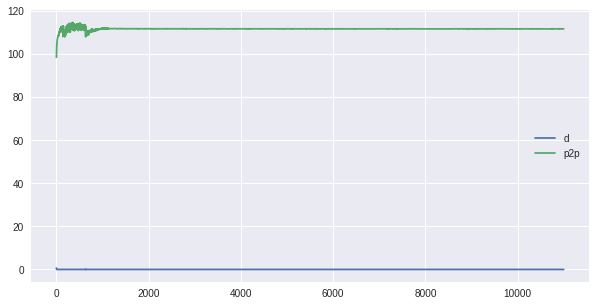

In [33]:
plt.figure(figsize=(10,5))
plt.plot(losses['d'], label='d')
plt.plot(losses['p2p'], label='p2p')
plt.legend()

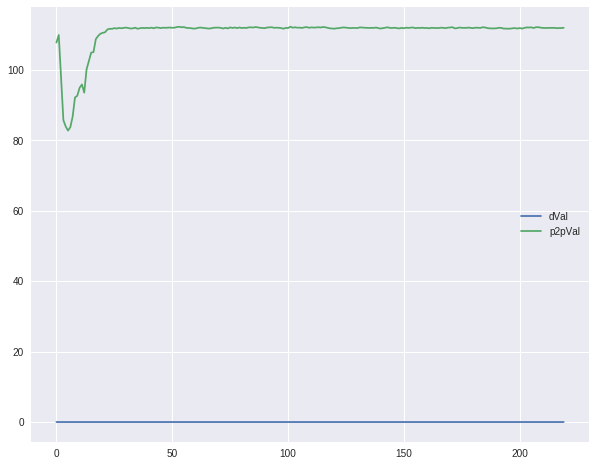

In [34]:
plt.figure(figsize=(10,8))
plt.plot(losses['dVal'], label='dVal')
plt.plot(losses['p2pVal'], label='p2pVal')
plt.legend()

In [7]:
f_gen.save_weights('../data/sand/trend1/f_gen.weights')
d.save_weights('../data/sand/trend1/d.weights')
p2p.save_weights('../data/sand/trend1/p2p.weights')

NameError: name 'f_gen' is not defined

In [66]:
np.save('../data/sand/trend1/losses.npy', losses)

NameError: name 'dictionary' is not defined

In [37]:
TestIMS1, TestIMS2, TestPan = next(valGen)

In [38]:
TestIMS1 = (127.5 * (TestIMS1[0].reshape(100, 100).T) + 127.5).astype('uint8')

In [39]:
TestIMS2 = (127.5 * (TestIMS2[0].reshape(100, 100).T) + 127.5).astype('uint8')

In [40]:
TestPan = (127.5 * (TestPan[0].reshape(500, 100).T) + 127.5).astype('uint8')

In [41]:
IMPan = Image.fromarray(TestPan, mode='L')
ImSide1 = Image.fromarray(TestIMS1, mode='L')
ImSide2 = Image.fromarray(TestIMS2, mode='L')

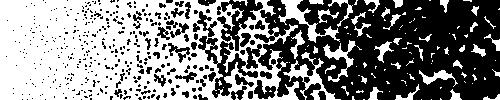

In [42]:
IMPan

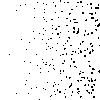

In [43]:
ImSide1

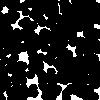

In [44]:
ImSide2

In [45]:
input1 = ((np.array(ImSide1) - 127.5) / 127.5).reshape(1, 100, 100, 1)

In [46]:
input2 = ((np.array(ImSide2) - 127.5) / 127.5).reshape(1, 100, 100, 1)

In [47]:
PRED = f_gen.predict([input1, input2])

In [48]:
imPREDarr = (127.5 * (PRED.reshape(500, 100).T) + 127.5).astype('uint8')

In [49]:
imPRED = Image.fromarray(imPREDarr, mode='L')

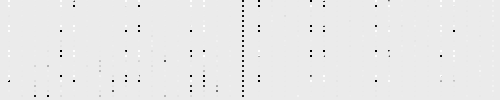

In [50]:
imPRED

In [8]:
from keras.utils import plot_model
plot_model(f_gen, to_file='f_gen.png', show_shapes=True, show_layer_names=True)
plot_model(d, to_file='d.png', show_shapes=True, show_layer_names=True)
plot_model(p2p, to_file='p2p.png', show_shapes=True, show_layer_names=True)

In [10]:
import pydot

In [11]:
pydot.find_graphviz()

AttributeError: module 'pydot' has no attribute 'find_graphviz'